#Task 3

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
# %config InlineBackend.figure_format = 'retina'
# from google.colab.patches import cv2_imshow
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [3]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [4]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
print(img)

torch.Size([3, 1365, 2048])
tensor([[[ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         [ 79,  80,  80,  ...,  75,  75,  76],
         ...,
         [121, 121, 122,  ...,  97,  96,  96],
         [121, 121, 122,  ...,  97,  97,  96],
         [121, 121, 122,  ...,  98,  97,  97]],

        [[ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         [ 52,  53,  53,  ...,  55,  55,  54],
         ...,
         [103, 103, 104,  ...,  82,  81,  81],
         [103, 103, 104,  ...,  82,  82,  81],
         [103, 103, 104,  ...,  83,  82,  82]],

        [[ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         [ 35,  36,  36,  ...,  30,  30,  30],
         ...,
         [ 37,  37,  38,  ...,  43,  42,  42],
         [ 37,  37,  38,  ...,  43,  43,  42],
         [ 37,  37,  38,  ...,  44,  43,  43]]], dtype=torch.uint8)


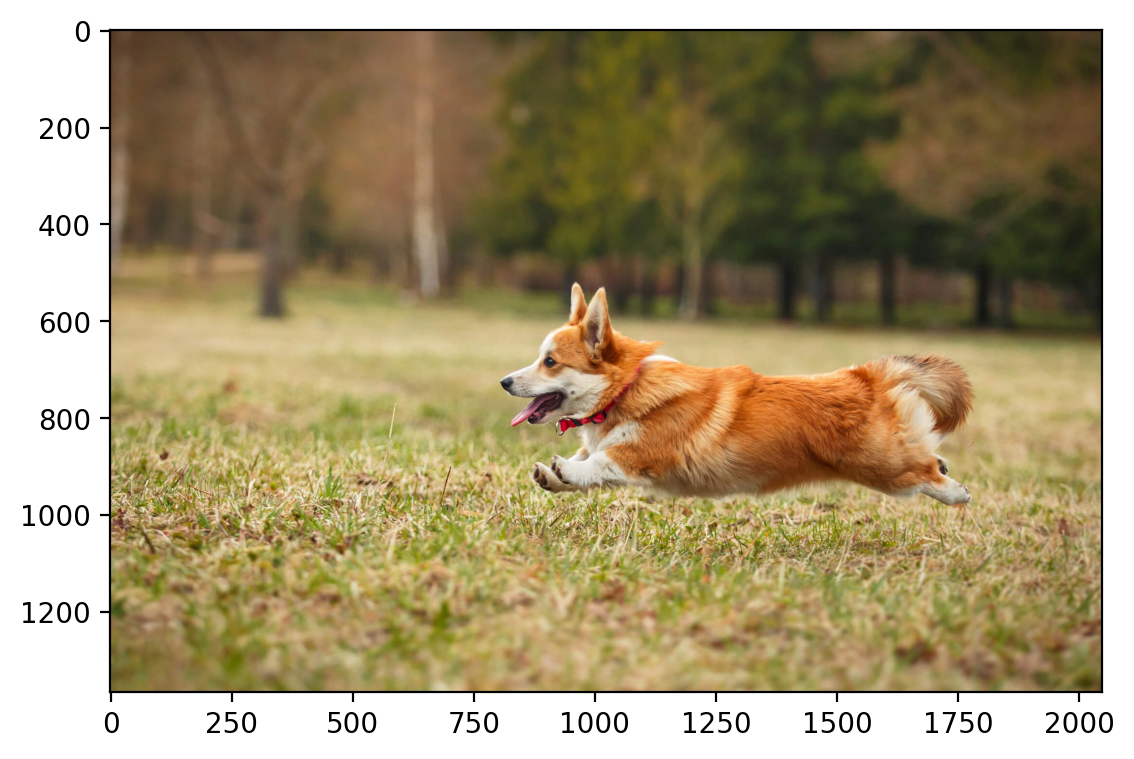

In [8]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())


read the input image

In [9]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [10]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print(img_scaled.shape)
print(type(img_scaled))
img_scaled = torch.tensor(img_scaled)

(3, 1365, 2048)
<class 'numpy.ndarray'>


In [11]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

applied min max scaling to the input image

In [12]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 400,400)
crop.shape

torch.Size([3, 400, 400])

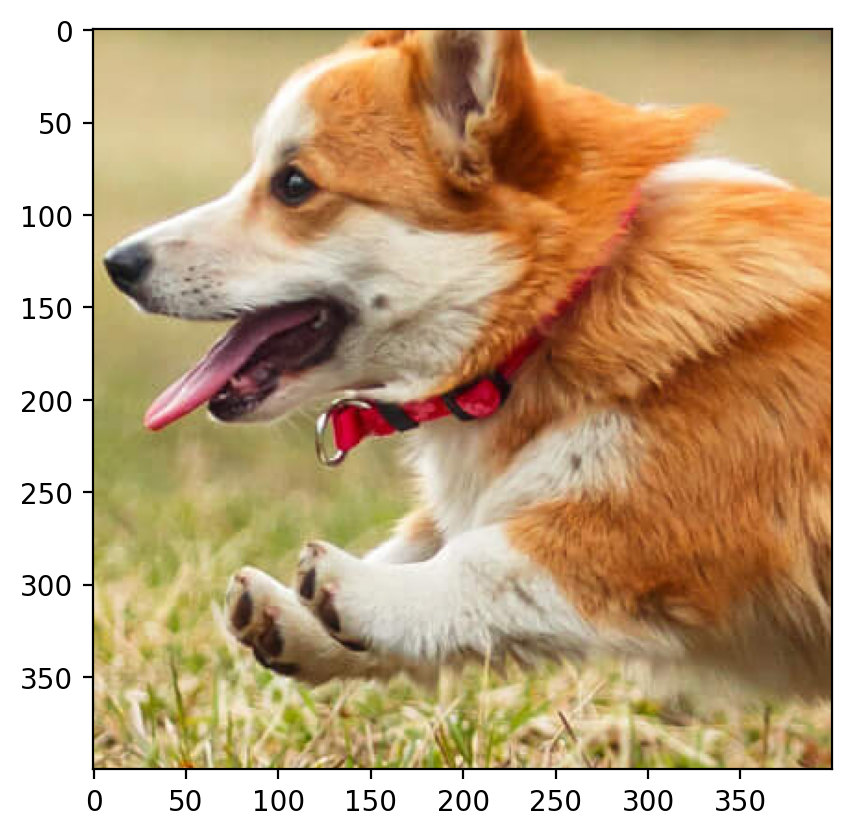

In [13]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

croped the image to 400*400 image

In [14]:
transform = transforms.Resize((200,200))
resized_img = transform(crop)
resized_img.shape

torch.Size([3, 200, 200])

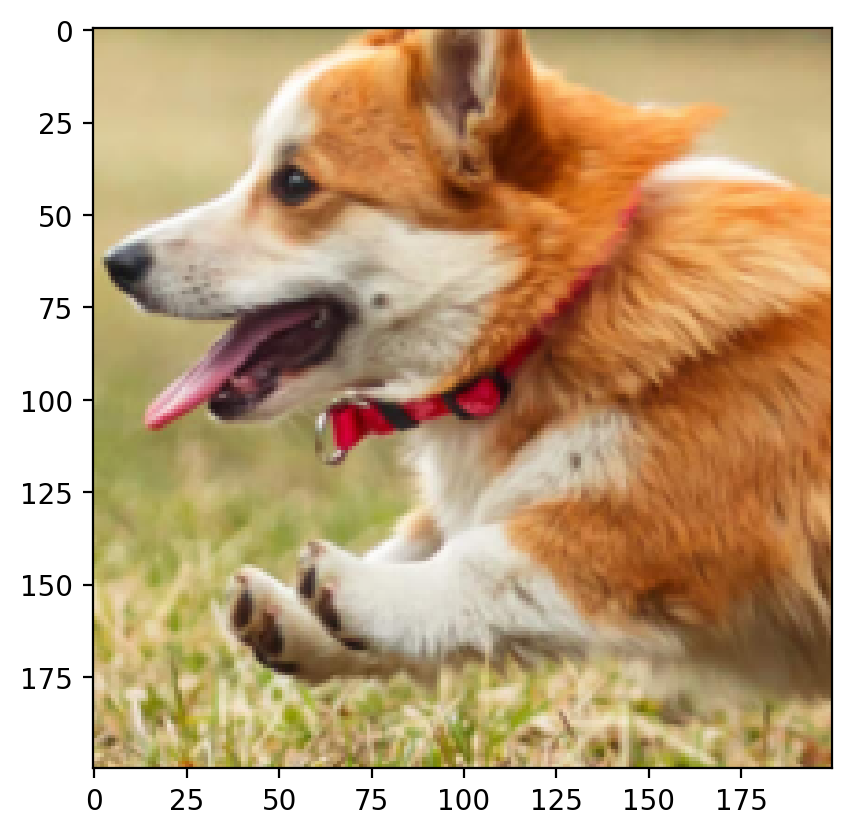

In [15]:
plt.imshow(rearrange(resized_img, 'c h w -> h w c').cpu().numpy())

resized image to 200*200

In [16]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [17]:
dog_X, dog_Y = create_coordinate_map(resized_img)

dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [18]:
dog_X

tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]])

In [19]:
dog_Y

tensor([[0.7714, 0.6969, 0.4773],
        [0.7714, 0.6969, 0.4773],
        [0.7714, 0.6969, 0.4773],
        ...,
        [0.6284, 0.4981, 0.1959],
        [0.6756, 0.5104, 0.2506],
        [0.7200, 0.5279, 0.3184]])

creating X(h,w) and Y(r,g,b)

In [20]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

print(dog_X_scaled.shape)
print(dog_Y.shape)

torch.Size([40000, 2])
torch.Size([40000, 3])


creating scaled X coordinates

In [21]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [22]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [23]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [24]:
train(net, 0.01, dog_X_scaled, dog_Y, 1000)

Epoch 0 loss: 0.380953
Epoch 100 loss: 0.036115
Epoch 200 loss: 0.032893
Epoch 300 loss: 0.032892
Epoch 400 loss: 0.032892
Epoch 500 loss: 0.032892
Epoch 600 loss: 0.032892
Epoch 700 loss: 0.032892
Epoch 800 loss: 0.032892
Epoch 900 loss: 0.032892


0.032892368733882904

linear regression part

In [25]:
def dix():
    # num_channels, height, width = img.shape

        # Create a 2D grid of (x,y) coordinates (h, w)
        # width values change faster than height values
    w_coords = torch.arange(0,200,0.5).repeat(200, 1)
    h_coords = torch.arange(0,200,0.5).repeat(200, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

        # Combine the x and y coordinates into a single tensor
    dX = torch.stack([h_coords, w_coords], dim=1).float()

      # Move X to GPU if available
    dX = dX.to(device)
    return dX

In [26]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

image construction function

In [27]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [28]:
X_rff = create_rff_features(dog_X_scaled, 37500, 0.008)

In [29]:
X_rff.shape

torch.Size([40000, 37500])

In [30]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, dog_Y, 200)

Epoch 0 loss: 0.367427
Epoch 100 loss: 0.041361
Epoch 200 loss: 0.006494
Epoch 300 loss: 0.002522
Epoch 400 loss: 0.001208
Epoch 500 loss: 0.000600
Epoch 600 loss: 0.000315
Epoch 700 loss: 0.000184
Epoch 800 loss: 0.000124
Epoch 900 loss: 0.000096
Epoch 1000 loss: 0.000082
Epoch 1100 loss: 0.000076
Epoch 1200 loss: 0.000072
Epoch 1300 loss: 0.000070
Epoch 1400 loss: 0.000069
Epoch 1500 loss: 0.000068
Epoch 1600 loss: 0.000067
Epoch 1700 loss: 0.000067
Epoch 1800 loss: 0.000066
Epoch 1900 loss: 0.000066


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


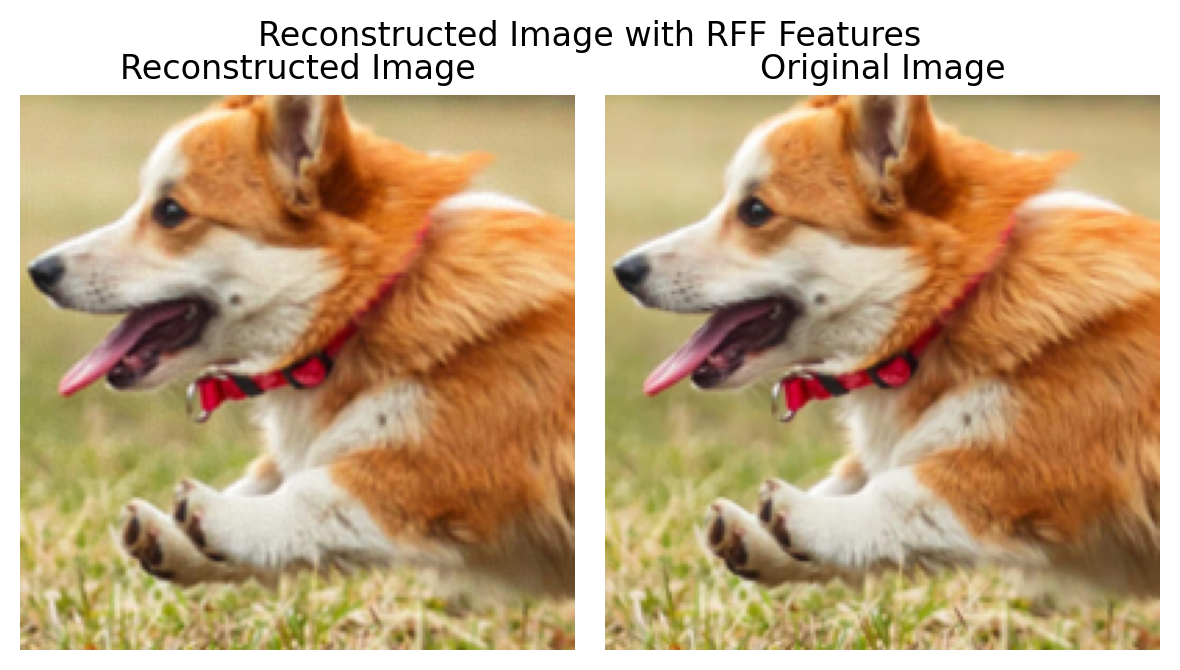

In [31]:
plot_reconstructed_and_original_image(resized_img, net, X_rff, title="Reconstructed Image with RFF Features")

rff

In [ ]:
# w = 200
# scale=2
# torch.arange(0, w, 1/scale)

In [32]:
def create_coordinate_map(img, scale=2):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [33]:
dix=create_coordinate_map(resized_img, scale=2)[0].shape
xis=create_coordinate_map(resized_img, scale=2)[0]
#resized_img
plot_reconstructed_and_original_image(resized_img, net, xis, title="Superposed Image with RFF Features")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160000x2 and 37500x3)

Q-2 RMSE AND PSNR

In [34]:
def calculate_rmse(original, reconstructed):
    if isinstance(original, torch.Tensor):
        original = original.detach().numpy()
    if isinstance(reconstructed, torch.Tensor):
        reconstructed = reconstructed.detach().numpy()
    
    # Handle NaN values
    valid_mask = np.isfinite(original) & np.isfinite(reconstructed)
    
    # Apply the mask to filter out NaN values
    original = original[valid_mask]
    reconstructed = reconstructed[valid_mask]
    
    # Check if there are any valid values left
    if original.size == 0:
        raise ValueError("No valid data points left after removing NaN values")
    
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)
    return rmse
    
print("RMSE is:",calculate_rmse(crop ,resized_img ))

#calculating PSNR
def calculate_psnr(original, reconstructed, max_pixel=255.0):
    # Compute the RMSE
    rmse = calculate_rmse(original, reconstructed)
    
    # Compute the PSNR
    if rmse == 0:
        return float('inf')  # PSNR is infinite if there is no error
    psnr = 10 * np.log10((max_pixel ** 2) / (rmse ** 2))
    return psnr

print("PSNR is: ",calculate_psnr(crop,resized_img ))
    

ValueError: operands could not be broadcast together with shapes (3,400,400) (3,200,200) 